In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

**Data Path**

In [ ]:
path = '/content/drive/MyDrive/chest_xray'

**Train, Valid, and Test Path**

In [ ]:
train_path = os.path.join(path, "train")
valid_path = os.path.join(path, "val")
test_path = os.path.join(path, "test")

**Data Collection**

In [ ]:
train_normal = glob.glob(os.path.join(train_path, "NORMAL", "*.jpeg"))
train_pneumonia = glob.glob(os.path.join(train_path, "PNEUMONIA", "*.jpeg"))

valid_normal = glob.glob(os.path.join(valid_path, "NORMAL", "*.jpeg"))
valid_pneumonia = glob.glob(os.path.join(valid_path, "PNEUMONIA", "*.jpeg"))

test_normal = glob.glob(os.path.join(test_path, "NORMAL", "*.jpeg"))
test_pneumonia = glob.glob(os.path.join(test_path, "PNEUMONIA", "*.jpeg"))

**Data Preparation**

In [ ]:
train_normal = [os.path.join(train_path, "NORMAL", img) for img in os.listdir(os.path.join(train_path, "NORMAL")) if img.endswith('.jpeg')]
train_pneumonia = [os.path.join(train_path, "PNEUMONIA", img) for img in os.listdir(os.path.join(train_path, "PNEUMONIA")) if img.endswith('.jpeg')]
train = pd.DataFrame({'image': train_normal + train_pneumonia, 'class': ['Normal'] * len(train_normal) + ['Pneumonia'] * len(train_pneumonia)})

valid_normal = [os.path.join(valid_path, "NORMAL", img) for img in os.listdir(os.path.join(valid_path, "NORMAL")) if img.endswith('.jpeg')]
valid_pneumonia = [os.path.join(valid_path, "PNEUMONIA", img) for img in os.listdir(os.path.join(valid_path, "PNEUMONIA")) if img.endswith('.jpeg')]
valid = pd.DataFrame({'image': valid_normal + valid_pneumonia, 'class': ['Normal'] * len(valid_normal) + ['Pneumonia'] * len(valid_pneumonia)})

test_normal = [os.path.join(test_path, "NORMAL", img) for img in os.listdir(os.path.join(test_path, "NORMAL")) if img.endswith('.jpeg')]
test_pneumonia = [os.path.join(test_path, "PNEUMONIA", img) for img in os.listdir(os.path.join(test_path, "PNEUMONIA")) if img.endswith('.jpeg')]
test = pd.DataFrame({'image': test_normal + test_pneumonia, 'class': ['Normal'] * len(test_normal) + ['Pneumonia'] * len(test_pneumonia)})

Succesfully created train, valid, and test dataframes.

**Train Data Distribution**

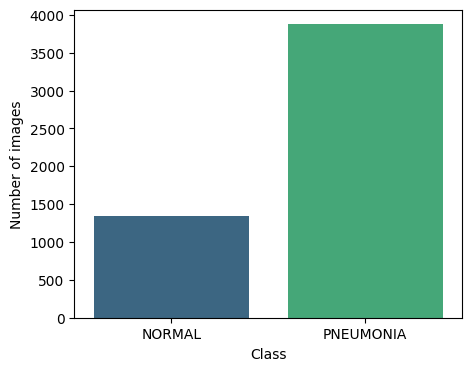

In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x='class', data = train, palette="viridis")

plt.xlabel("Class")
plt.ylabel("Number of images")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

**Valid Data Distribution**

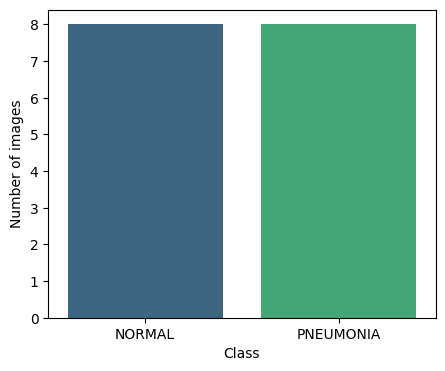

In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x='class', data = valid, palette="viridis")

plt.xlabel("Class")
plt.ylabel("Number of images")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

**Test Data Distribution**

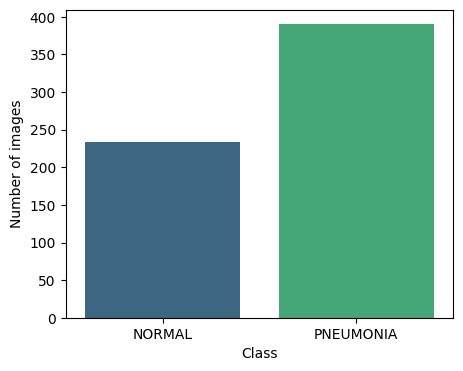

In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x='class', data = test, palette="viridis")

plt.xlabel("Class")
plt.ylabel("Number of images")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

**Train data - Normal Images**

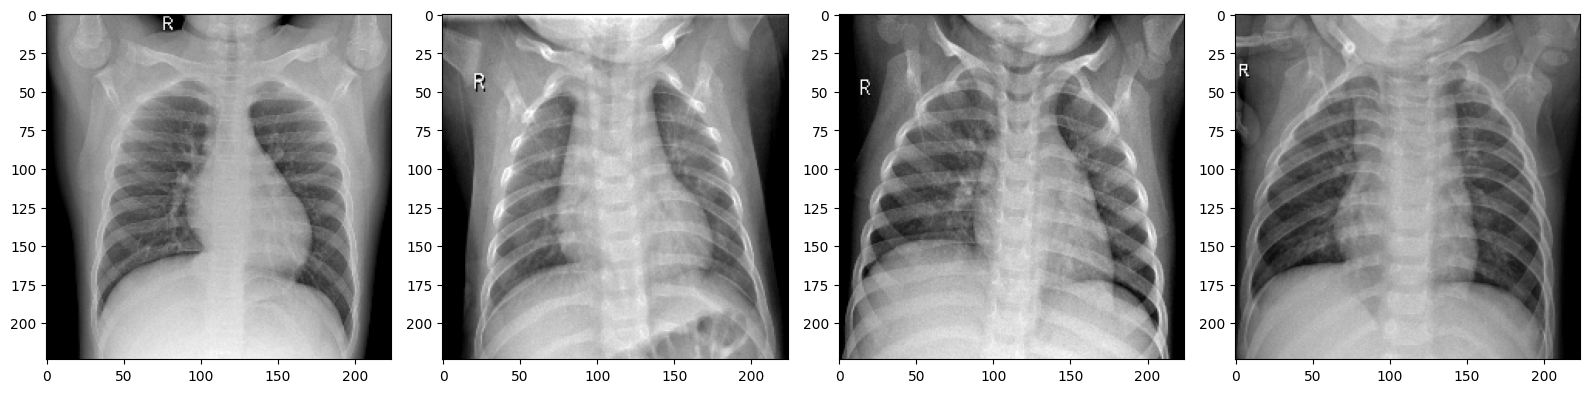

In [ ]:
plt.figure(figsize=(16, 9))
for i in range(4):
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (224, 224))

    plt.subplot(1, 4, i + 1)
    plt.imshow(img)

plt.tight_layout()
plt.show()

**Train data - Pneumonia images**

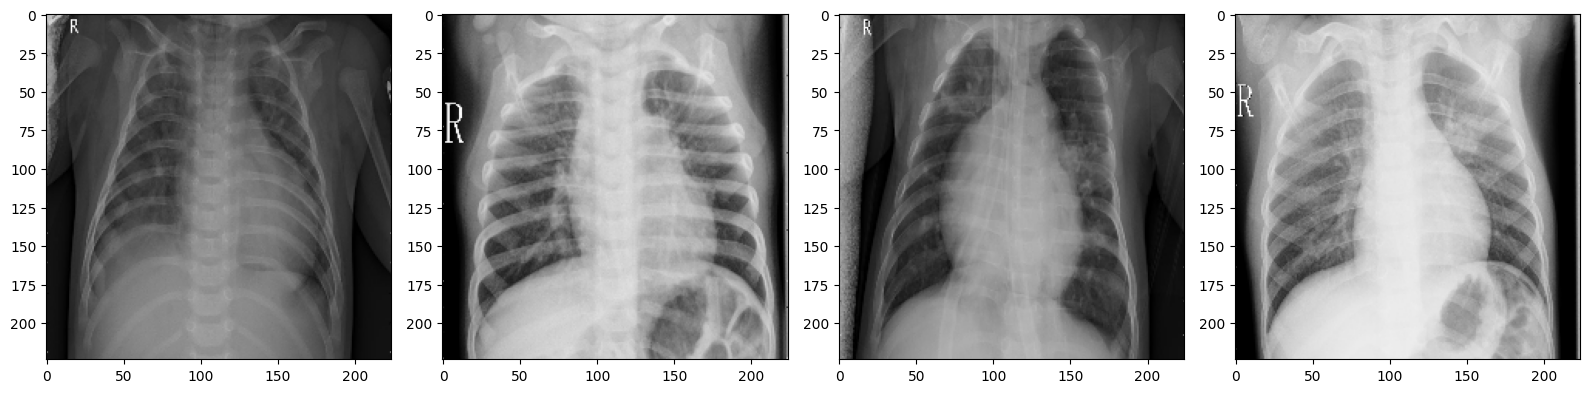

In [ ]:
plt.figure(figsize=(16, 9))
for i in range(4):
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (224, 224))

    plt.subplot(1, 4, i + 1)
    plt.imshow(img)

plt.tight_layout()
plt.show()

**Data Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_data = train_datagen.flow_from_dataframe(train,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (224, 224),
                                             class_mode = 'binary',
                                             batch_size = 16,
                                             shuffle = False)

valid_data = val_datagen.flow_from_dataframe(valid,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (224, 224),
                                            class_mode = 'binary',
                                            batch_size = 16,
                                            shuffle = False)

test_data = test_datagen.flow_from_dataframe(test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (224, 224),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


**CNN Model Architecture**

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16, kernel_size=3, padding='valid', input_shape=(224, 224, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=32, kernel_size=3, padding='valid'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=64, kernel_size=3, padding='valid'))
model.add(layers.Conv2D(filters=64, kernel_size=3, padding='valid'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

**Model Compilation**

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=3e-5),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 batch_normalization_23 (Ba  (None, 222, 222, 16)      64        
 tchNormalization)                                               
                                                                 
 activation_3 (Activation)   (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 111, 111, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 111, 111, 16)      0         
                                                                 
 conv2d_36 (Conv2D)          (None, 109, 109, 32)     

**Training Callbacks**

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-7,
    cooldown = 0,
    verbose = 1
)

**Model Training**

In [ ]:
mdl = model.fit(train_data, epochs = 10, validation_data=valid_data, callbacks=[early_stopping, plateau])

Epoch 1/10
326/326 [==============================] - 521s 2s/step - loss: 0.6772 - accuracy: 0.7264 - val_loss: 0.7128 - val_accuracy: 0.5000 - lr: 3.0000e-05
Epoch 2/10
326/326 [==============================] - 510s 2s/step - loss: 0.5159 - accuracy: 0.7565 - val_loss: 0.6497 - val_accuracy: 0.6875 - lr: 3.0000e-05
Epoch 3/10
326/326 [==============================] - 505s 2s/step - loss: 0.4369 - accuracy: 0.7801 - val_loss: 0.6337 - val_accuracy: 0.5625 - lr: 3.0000e-05
Epoch 4/10
326/326 [==============================] - 503s 2s/step - loss: 0.3685 - accuracy: 0.7972 - val_loss: 0.5799 - val_accuracy: 0.6875 - lr: 3.0000e-05
Epoch 5/10
326/326 [==============================] - 498s 2s/step - loss: 0.3254 - accuracy: 0.8171 - val_loss: 0.6674 - val_accuracy: 0.6250 - lr: 3.0000e-05
Epoch 6/10
326/326 [==============================] - ETA: 0s - loss: 0.2961 - accuracy: 0.8512
Epoch 6: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
326/326 [==================

**Model Loss Visualization**

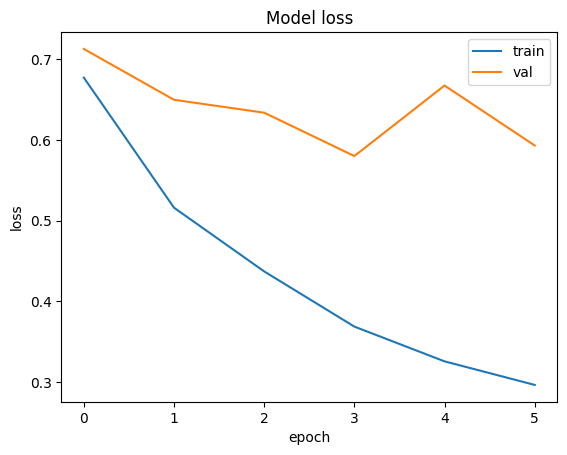

In [ ]:
plt.plot(mdl.history['loss'])
plt.plot(mdl.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

**Model Accuracy Visualization**

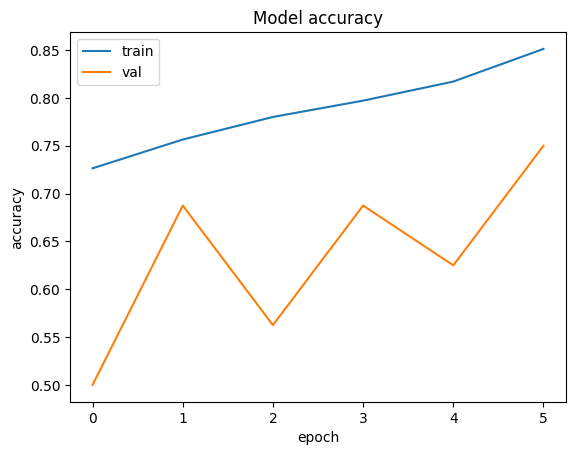

In [ ]:
plt.plot(mdl.history['accuracy'])
plt.plot(mdl.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Model Evaluation**

In [ ]:
score = model.evaluate(test_data, steps = len(test), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.44056710600852966
Test accuracy: 0.8221153616905212


**Label Encoding**

In [ ]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = test['class'].copy().map(num_label).astype('int')

In [ ]:
predictions = model.predict(test_data, steps=len(test_data), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [ ]:
from sklearn import metrics

**Classification Report**

In [ ]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78       234
           1       0.90      0.80      0.85       390

    accuracy                           0.82       624
   macro avg       0.81      0.83      0.82       624
weighted avg       0.83      0.82      0.82       624



**Confusion Matrix Heatmap**

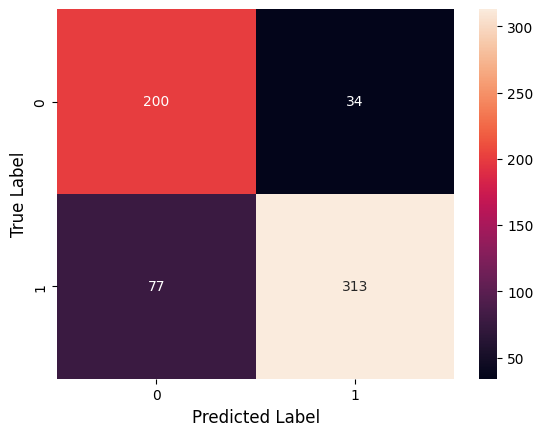

In [ ]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()